# Homework 10 - CIFAR10 Image Classification with PyTorch

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.9993, 0.3437, 0.3744],
        [0.3088, 0.7584, 0.7395],
        [0.5586, 0.5602, 0.3452],
        [0.2459, 0.2511, 0.7903],
        [0.2497, 0.5677, 0.3928]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [3]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [0]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [0]:
!mkdir hw10_data

In [6]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

0it [00:00, ?it/s]

100%|█████████▉| 170057728/170498071 [00:15<00:00, 10971001.82it/s]

Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [9]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

170500096it [00:30, 10971001.82it/s]                               

  Epoch 0 @ step 0: Train Loss: 0.004324, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.955044, Train Accuracy: 0.333875
  Epoch 0 @ step 2000: Train Loss: 1.829151, Train Accuracy: 0.350750
  Epoch 0 @ step 3000: Train Loss: 1.785266, Train Accuracy: 0.362125
  Epoch 0 @ step 4000: Train Loss: 1.764755, Train Accuracy: 0.365625
  Epoch 0 @ step 5000: Train Loss: 1.764189, Train Accuracy: 0.364375
  Epoch 0 @ step 6000: Train Loss: 1.745754, Train Accuracy: 0.372250
Epoch 0 Test Loss: 1.719569, Test Accuracy: 0.389900, time: 17.6s
  Epoch 1 @ step 7000: Train Loss: 1.759154, Train Accuracy: 0.371875
  Epoch 1 @ step 8000: Train Loss: 1.741706, Train Accuracy: 0.372000
  Epoch 1 @ step 9000: Train Loss: 1.758284, Train Accuracy: 0.377250
  Epoch 1 @ step 10000: Train Loss: 1.728995, Train Accuracy: 0.379125
  Epoch 1 @ step 11000: Train Loss: 1.738186, Train Accuracy: 0.380500
  Epoch 1 @ step 12000: Train Loss: 1.731788, Train Accuracy: 0.377000
Epoch 1 Test Loss: 1.714

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

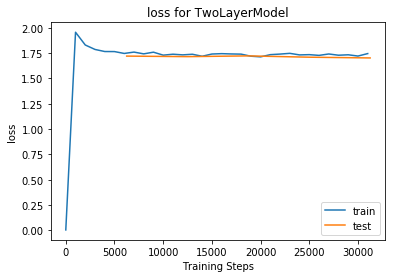

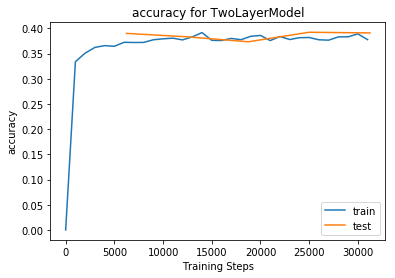

In [10]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [11]:
class ConvModel(nn.Module):
  def __init__(self):
    super(ConvModel, self).__init__()
    self.net = nn.Sequential(
      nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      Flatten(), 
      nn.Linear(4096, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004273, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.829109, Train Accuracy: 0.327125
  Epoch 0 @ step 2000: Train Loss: 1.595910, Train Accuracy: 0.417375
  Epoch 0 @ step 3000: Train Loss: 1.526866, Train Accuracy: 0.443875
  Epoch 0 @ step 4000: Train Loss: 1.456301, Train Accuracy: 0.472125
  Epoch 0 @ step 5000: Train Loss: 1.425297, Train Accuracy: 0.476625
  Epoch 0 @ step 6000: Train Loss: 1.406360, Train Accuracy: 0.489875
Epoch 0 Test Loss: 1.385647, Test Accuracy: 0.503600, time: 30.2s
  Epoch 1 @ step 7000: Train Loss: 1.383768, Train Accuracy: 0.501875
  Epoch 1 @ step 8000: Train Loss: 1.358080, Train Accuracy: 0.506125
  Epoch 1 @ step 9000: Train Loss: 1.355973, Train Accuracy: 0.516750
  Epoch 1 @ step 10000: Train Loss: 1.334774, Train Accuracy: 0.515125
  Epoch 1 @ step 11000: Train Loss: 1.322293, Train Accuracy: 0.518000
  Epoch 1 @ step 12000: Train Loss: 1.323277, Train Accuracy: 0.525125
Epoch 1 Test Loss: 1.419

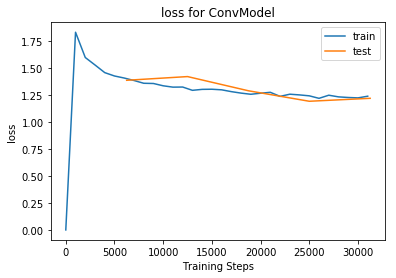

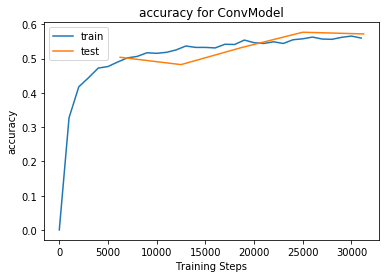

In [12]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1? Yes, the accuracy has gone up by over 15% compared to the first run.

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [26]:
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, depth, num_classes=1000):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
        n = (depth - 2) // 6

        block = Bottleneck if depth >=44 else BasicBlock

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet(**kwargs):
    """
    Constructs a ResNet model.
    """
    return ResNet(**kwargs)

class AwesomeModel(nn.Module):
  def __init__(self):
    super(AwesomeModel, self).__init__()
    self.net = nn.Sequential(
#       nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#       nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#       nn.ReLU(),
#       nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#       nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#       nn.ReLU(),
      ResNet(20, num_classes=10))
#       Flatten(), 
#       nn.Linear(1024, 256), 
#       nn.ReLU(),
#       nn.Linear(256, 16), 
#       nn.ReLU(),
#       nn.Linear(16, 10))
    
  def forward(self, x):
    return self.net(x)

model = AwesomeModel().to(device)

loss = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
training_epochs = 10
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004696, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 2.025736, Train Accuracy: 0.229125
  Epoch 0 @ step 2000: Train Loss: 1.801900, Train Accuracy: 0.317750
  Epoch 0 @ step 3000: Train Loss: 1.682974, Train Accuracy: 0.371000
  Epoch 0 @ step 4000: Train Loss: 1.589041, Train Accuracy: 0.419625
  Epoch 0 @ step 5000: Train Loss: 1.505890, Train Accuracy: 0.450250
  Epoch 0 @ step 6000: Train Loss: 1.420341, Train Accuracy: 0.482625
Epoch 0 Test Loss: 1.260020, Test Accuracy: 0.538700, time: 124.2s
  Epoch 1 @ step 7000: Train Loss: 1.340948, Train Accuracy: 0.512875
  Epoch 1 @ step 8000: Train Loss: 1.300568, Train Accuracy: 0.532625
  Epoch 1 @ step 9000: Train Loss: 1.254717, Train Accuracy: 0.555125
  Epoch 1 @ step 10000: Train Loss: 1.222439, Train Accuracy: 0.557750
  Epoch 1 @ step 11000: Train Loss: 1.198714, Train Accuracy: 0.575625
  Epoch 1 @ step 12000: Train Loss: 1.159435, Train Accuracy: 0.593875
Epoch 1 Test Loss: 1.03

**What changes did you make to improve your model?** I started by changing the optimizer and modifying the number of epochs. I found that the optimizer can give some quick improvements, but more epochs often led to overfitting on the training data after a certain point. I then moved to adding a fully connected layer, but that resulted in similar numbers. I added a convolutional layer, and that also gave about the same numbers as my other changes. I then combined the two changes and got a similar result. I then increased the learning rate by an order of magnitude thinking it wasn't working fast enough, but this had horrible results. I then added epochs and reverted the learning rate change to see if that helped. This resulted in a slighty better outcome. I then decided to switch to a resnet implementation from Facebook. This increased my accuracy by about 10% without overfitting at 10 epochs. My research showed many models being trained for 200 or 300 epochs. I decided to increase my resnet depth first from 20 to 110, and then increase my epochs to 200. I then realized this would take several days to complete, so I decided to turn in this homework and go back to this later. I might try random image occlusion as well as the additional training I have mentioned here. I may also try a densenet, but the performance of the resnet has been pretty good so far.

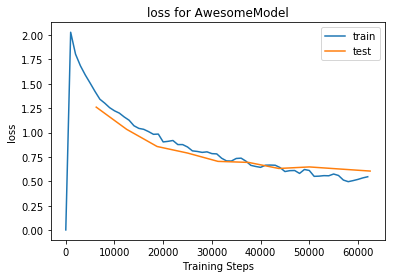

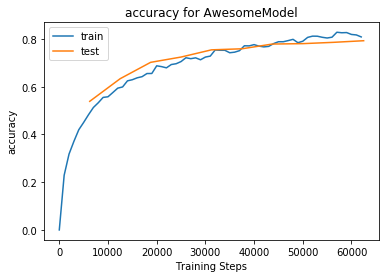

In [29]:
plot_graphs("AwesomeModel", metrics)

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [0]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-24 04:19:09--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-24 04:19:09--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip.1’

test_file.zip.1     100%[===================>]   3.66M  1.91MB/s    in 1.9s    

2019-04-24 04:19:12 (1.91 MB/s) - ‘test_file.zip.1’ saved [3841776/3841776]

Archive:  test_file.zip
replace test_file.pt? [y]es, [n]o, [A]ll, [N]one, 

Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
import torch.utils.data as Data

val_file = 'test_file.pt'
pred_file = 'submission.txt'

f_pred = open(pred_file,'w') 
val_tensor = torch.load(val_file)
val_dataset = Data.TensorDataset(val_tensor)  
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2)

model.eval()
with torch.no_grad():
  for images in val_loader:
    for image in images:
      image = image.to(device)
      output = model(image.view(8, 3, 32, 32))
      results = torch.argmax(output, dim=1)
      for result in results:
        value = result.item()
        f_pred.write(str(value))
        f_pred.write('\n')
    
f_pred.close()


# Report

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

Test (on validation set) accuracy (5 Points): 0.394100

Test loss (5 Points): 1.712688

Training time (5 Points): 88.5s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

- Plot a graph of loss on validation set vs training steps (5 Points)


## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

Output dimension after 1st conv layer: 8, 16, 32, 32

Output dimension after 1st max pooling: 8, 16, 16, 16

Output dimension after 2nd conv layer: 8, 16, 16, 16

Output dimension after flatten layer: 8, 4096

Output dimension after 1st fully connected layer: 8, 64

Output dimension after 2nd fully connected layer: 8, 10


Test (on validation set) Accuracy (5 Points): 0.566500

Test loss (5 Points): 1.202395

Training time (5 Points): 126.5s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

- Plot a graph of loss on validation set vs training steps (5 Points)



## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):

I started by changing the optimizer and modifying the number of epochs. I found that the optimizer can give some quick improvements, but more epochs often led to overfitting on the training data after a certain point. I then moved to adding a fully connected layer, but that resulted in similar numbers. I added a convolutional layer, and that also gave about the same numbers as my other changes. I then combined the two changes and got a similar result. I then increased the learning rate by an order of magnitude thinking it wasn't working fast enough, but this had horrible results. I then added epochs and reverted the learning rate change to see if that helped. This resulted in a slighty better outcome. I then decided to switch to a resnet implementation from Facebook. This increased my accuracy by about 10% without overfitting at 10 epochs. My research showed many models being trained for 200 or 300 epochs. I decided to increase my resnet depth first from 20 to 110, and then increase my epochs to 200. I then realized this would take several days to complete, so I decided to turn in this homework and go back to this later. I might try random image occlusion as well as the additional training I have mentioned here. I may also try a densenet, but the performance of the resnet has been pretty good so far.


Test (on validation set) Accuracy (5 Points): 0.792600

Test loss (5 Points): 0.606425

Training time (5 Points): 1234.0s


Plots:

- Plot a graph of accuracy on validation set vs training steps (5 Points)

- Plot a graph of loss on validation set vs training steps (5 Points)

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)